In [1]:
!pip3 install transformers

In [2]:
from collections import defaultdict
# import gdown
# import gzip
# import json
import random
# import pickle

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
sns.set(style='ticks', font_scale=1.2)

<br><br>

## **Set parameters and file paths**

In [3]:
# This is the name of the BERT model that we want to use. 
# We're using DistilBERT to save space (it's a distilled version of the full BERT model), 
# and we're going to use the cased (vs uncased) version.
model_name = 'distilbert-base-cased'  

# This is the name of the program management system for NVIDIA GPUs. We're going to send our code here.
device_name = 'cuda'       

# This is the maximum number of tokens in any document sent to BERT.
max_length = 512                                                        

# This is the name of the directory where we'll save our model. You can name it whatever you want.
cached_model_directory_name = 'distilbert-suicidal-content-reviews'  

<br><br>

## **Load and sample Goodreads data**

In [4]:
import pandas as pd
dataframe = pd.read_csv('/kaggle/input/suicide-watch/Suicide_Detection.csv')
dataframe.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [5]:
suicide = dataframe[dataframe['class']=='suicide']
non_suicide = dataframe[dataframe['class']=='non-suicide']
suicide.shape, non_suicide.shape

((116037, 3), (116037, 3))

In [6]:
suicide = suicide.head(60000)
non_suicide = non_suicide.head(60000)
dataframe = pd.concat([suicide,non_suicide])
dataframe.head(10)

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
5,11,Honetly idkI dont know what im even doing here...,suicide
6,12,[Trigger warning] Excuse for self inflicted bu...,suicide
7,13,It ends tonight.I can’t do it anymore. \nI quit.,suicide
9,18,My life is over at 20 years oldHello all. I am...,suicide
10,19,I took the rest of my sleeping pills and my pa...,suicide
11,20,Can you imagine getting old? Me neither.Wrinkl...,suicide
12,21,Do you think getting hit by a train would be p...,suicide


In [7]:
dataframe = dataframe.sample(frac = 1)
dataframe.head(10)

,Unnamed: 0,text,class
89787,134872,I don't want to live anymoreI'm an awful perso...,suicide
104247,156681,"Sorry to bother you, but i'm in desperate need...",suicide
76335,114606,need helphey uhm i know you guys don’t really ...,suicide
40625,60930,i dont know what to do anymorehey. im in a rea...,suicide
9387,14101,Any girls here who are dom but also sweet and ...,non-suicide
22235,33453,vroom vroom racecar spelled backwards is \n\nr...,non-suicide
96115,144344,We need to stop spending money on awards. It b...,non-suicide
89984,135168,This should be good enough Do I finally have e...,non-suicide
52008,77890,I can't sleep man I still have to do shit for ...,non-suicide
98328,147746,Posting jokes Until im not depressed day 2 The...,non-suicide


In [8]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120000 entries, 89787 to 48532
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  120000 non-null  int64 
 1   text        120000 non-null  object
 2   class       120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


In [9]:
dataframe.isnull().sum()

Unnamed: 0    0
text          0
class         0
dtype: int64

# pre-processing

In [10]:
import re
!pip install autocorrect
from autocorrect import Speller
!pip install unidecode
import unidecode
!pip install contractions
import contractions
from string import punctuation

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 16.0 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622381 sha256=f8e4c68de6fdd33f2f74415cf979480b7feb411d9c7eaf990746001f85a95ba7
  Stored in directory: /root/.cache/pip/wheels/df/59/04/cc1520fa0644648667e8fd5dad4cf7a51f08b630f1dec39961
Successfully built autocorrect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 11.2 MB/s eta 0:00:00


In [11]:
def text_cleaning(text):
    # lower case
    text = text.lower()

    # html tags
    html_pattern = r'<.*?>'
    text = re.sub(pattern=html_pattern, repl=' ', string=text)

    # urls
    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(pattern=url_pattern, repl=' ', string=text)

    # numbers
    number_pattern = r'\d+'
    text = re.sub(pattern=number_pattern, repl=' ', string=text)

    # unidecode
    text = unidecode.unidecode(text)

    # Expanding Contractions
    text = contractions.fix(text)

    # remove punctutation
    text = text.translate(str.maketrans('', '', punctuation))

    # removing single characters
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    text = re.sub(pattern=single_char_pattern, repl=" ", string=text)

    # Extra spaces
    space_pattern = r'\s+'
    text = re.sub(pattern=space_pattern, repl=" ", string=text)

    return text


In [12]:
dataframe['text'] = dataframe['text'].apply(text_cleaning)
dataframe.head(10)

,Unnamed: 0,text,class
89787,134872,i do not want to live anymoreim an awful perso...,suicide
104247,156681,sorry to bother you but am in desperate need f...,suicide
76335,114606,need helphey uhm know you guys do not really g...,suicide
40625,60930,i do not know what to do anymorehey am in real...,suicide
9387,14101,any girls here who are dom but also sweet and ...,non-suicide
22235,33453,vroom vroom racecar spelled backwards is a e a...,non-suicide
96115,144344,we need to stop spending money on awards it be...,non-suicide
89984,135168,this should be good enough do finally have eno...,non-suicide
52008,77890,i cannot sleep man still have to do shit for s...,non-suicide
98328,147746,posting jokes until am not depressed day there...,non-suicide


<br><br>

## **Split the data into training and test sets**

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataframe['text'], dataframe['class'], test_size=0.33, random_state=42)

In [14]:
train_texts = X_train.tolist()
train_labels = y_train.tolist()
test_texts = X_test.tolist()
test_labels = y_test.tolist()


In [15]:
len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(80400, 80400, 39600, 39600)

In [16]:
train_labels[0], train_texts[0]

('non-suicide',
 'like that shit happened you ever feel like your grandparents stories sound like total bullshit like guys were drunk in the middle of the day did not see fucking gun on your side like that shit happened and if it did where is the proof seeing that every little thing ends up on the news')

In [17]:
len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(80400, 80400, 39600, 39600)

In [18]:
train_labels[0], train_texts[0]

('non-suicide',
 'like that shit happened you ever feel like your grandparents stories sound like total bullshit like guys were drunk in the middle of the day did not see fucking gun on your side like that shit happened and if it did where is the proof seeing that every little thing ends up on the news')

In [19]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

In [20]:
model = LogisticRegression(max_iter=1000).fit(X_train, train_labels)
predictions = model.predict(X_test)

In [21]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

 non-suicide       0.92      0.94      0.93     19877
     suicide       0.94      0.92      0.93     19723

    accuracy                           0.93     39600
   macro avg       0.93      0.93      0.93     39600
weighted avg       0.93      0.93      0.93     39600



In [22]:
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name) # The model_name needs to match our pre-trained model.

In [23]:
unique_labels = set(label for label in train_labels)
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

In [24]:
label2id.keys()

dict_keys(['non-suicide', 'suicide'])

In [25]:
id2label.keys()

dict_keys([0, 1])

In [26]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)

train_labels_encoded = [label2id[y] for y in train_labels]
test_labels_encoded  = [label2id[y] for y in test_labels]

In [27]:
' '.join(train_encodings[0].tokens[0:100])

'[CLS] like that shit happened you ever feel like your grandparents stories sound like total bullshit like guys were drunk in the middle of the day did not see fucking gun on your side like that shit happened and if it did where is the proof seeing that every little thing ends up on the news [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [28]:
' '.join(test_encodings[0].tokens[0:100])

'[CLS] lost all the feelings ##i mean still have some but they are just faded me and my mom have just returned from our trip to euro ##pe it was good although extremely t ##iring and stress ##ful but now am back to my grey life and studying again goddamn studying still have to choose themes for two diploma ##s am re ##cie ##ving two higher education grades at the same time and got no idea what to choose also it is about time for my third attempt to pass very difficult exam do not know the particular date but'

**Examine the training labels after encoding**

In [29]:
set(train_labels_encoded)

{0, 1}

**Examine the test labels after encoding**

In [30]:
set(test_labels_encoded)

{0, 1}

<br><br>

## **Make a custom Torch dataset**

In [31]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [32]:
train_dataset = MyDataset(train_encodings, train_labels_encoded)
test_dataset = MyDataset(test_encodings, test_labels_encoded)

In [33]:
' '.join(train_dataset.encodings[0].tokens[0:100])

'[CLS] like that shit happened you ever feel like your grandparents stories sound like total bullshit like guys were drunk in the middle of the day did not see fucking gun on your side like that shit happened and if it did where is the proof seeing that every little thing ends up on the news [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [34]:
' '.join(test_dataset.encodings[1].tokens[0:100])

'[CLS] i do not want to die ##im on s ##s ##ri and take h ##ydro ##xy ##zine for acute anxiety this usually su ##ff ##ices to keep me numb enough to function sometimes the darkness just wash ##es over me though and feel surrounded by decay somewhere beneath it all is still ##ness and rage quietly in b ##loom like midnight flower [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

<br><br>

## **Load pre-trained BERT model**

In [35]:
# The model_name needs to match the name used for the tokenizer above.
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(id2label)).to(device_name)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier

In [36]:
training_args = TrainingArguments(
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=5e-5,              # initial learning rate for Adam optimizer
    warmup_steps=500,                # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.01,               # strength of weight decay
    output_dir='./result',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=500,               # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

<br><br>

## **Fine-tune the BERT model**

In [37]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [38]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset (usually a validation set; here we just send our test set)
    compute_metrics=compute_metrics      # our custom evaluation function 
)

In [39]:
trainer.train()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Step,Training Loss,Validation Loss,Accuracy
500,0.258900,0.146628,0.960833
1000,0.105400,0.079883,0.971869
1500,0.095200,0.069511,0.974520
2000,0.075800,0.067449,0.976465
2500,0.066500,0.063736,0.977576


TrainOutput(global_step=2513, training_loss=0.11998674362435362, metrics={'train_runtime': 3794.3068, 'train_samples_per_second': 21.19, 'train_steps_per_second': 0.662, 'total_flos': 1.06503788519424e+16, 'train_loss': 0.11998674362435362, 'epoch': 1.0})

# push_to_hub

In [40]:
# model.save_pretrained("DistilBert-suicide-reviews1")

In [40]:
! pip install huggingface_hub

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [41]:
from huggingface_hub import notebook_login
notebook_login()

In [47]:
# trainer.push_to_hub("DistilBert-suicide-reviews")
model.push_to_hub("DistilBert-suicidal-content-reviews")
tokenizer.push_to_hub("DistilBert-suicidal-content-reviews")

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/263M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Prashant-karwasra/DistilBert-suicidal-content-reviews/commit/abe65f2398de1b7e86e6c49cf3cfc0838815db07', commit_message='Upload tokenizer', commit_description='', oid='abe65f2398de1b7e86e6c49cf3cfc0838815db07', pr_url=None, pr_revision=None, pr_num=None)

In [45]:
# trainer.push_to_hub("DistilBert-suicidal-content-reviews")

In [43]:
tokenizer.push_to_hub("DistilBert-suicidal-content-reviews")

CommitInfo(commit_url='https://huggingface.co/Prashant-karwasra/DistilBert-suicidal-content-reviews/commit/4fc717c6d30062c92277100f4cf7e28a22412f2e', commit_message='Upload tokenizer', commit_description='', oid='4fc717c6d30062c92277100f4cf7e28a22412f2e', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# trainer.push_to_hub("badh-m-ja")

In [48]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the model from the Hugging Face Hub
tokenizer11 = AutoTokenizer.from_pretrained("Prashant-karwasra/DistilBert-suicidal-content-reviews")
model11 = AutoModelForSequenceClassification.from_pretrained("Prashant-karwasra/DistilBert-suicidal-content-reviews")

In [49]:
review_text = "I hate my health...I'm 20 years old, male, and I've got problems.  I grew up in an abusive family, and I'm still living here.  I'm about to postpone college so I can move out, but those are little thing"
inputs = tokenizer11(review_text, return_tensors="pt")
outputs = model11(**inputs)
# print(outputs)
_, prediction = torch.max(outputs.logits, dim=1)
class_names = ['non-suicide','suicide']
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I hate my health...I'm 20 years old, male, and I've got problems.  I grew up in an abusive family, and I'm still living here.  I'm about to postpone college so I can move out, but those are little thing
Sentiment  : non-suicide


<br><br>

## **Save fine-tuned model**


In [50]:
trainer.save_model(cached_model_directory_name)

In [ ]:
# model.save_pretrained('./pretrained_model2')

In [ ]:
# model1 = DistilBertForSequenceClassification.from_pretrained(cached_model_directory_name).to(device_name)

In [ ]:
# review_text = "Who’s denser then Tungsten? It’s me I’ll keep this short so don’t expect good English and or full sentences. Last week was hanging out with friends at girls house. Get on topic of hu somehow. She says she’s had people hu in her bed but not her. Looks at me says my name and says u need to get w someone in my bed. I say u first (this is just coincidence I didn’t think anything of it). Later on everyone’s hanging out she says to me let’s go upstairs. Dumbass me says we’re having fun let’s stay down here."
# # review_text = " i want to die"
# encoded_review = tokenizer(
#   review_text,
#   max_length=max_length,
#   add_special_tokens=True,
#   return_token_type_ids=False,
#   pad_to_max_length=True,
#   return_attention_mask=True,
#   return_tensors='pt',
# )


# input_ids = encoded_review['input_ids'].to('cpu')
# attention_mask = encoded_review['attention_mask'].to('cpu')
# output = model3(input_ids, attention_mask)
# print(output.logits[:][0])
# _, prediction = torch.max(output.logits, dim=1)
# class_names = ['non-suicide','suicide']
# print(f'Review text: {review_text}')
# print(f'Sentiment  : {class_names[prediction]}')


# input_ids = encoded_review['input_ids'].to(device_name)
# attention_mask = encoded_review['attention_mask'].to(device_name)
# output = model1(input_ids, attention_mask)
# print(output.logits[:][0])
# _, prediction = torch.max(output.logits, dim=1)
# class_names = ['non-suicide','suicide']
# print(f'Review text: {review_text}')
# print(f'Sentiment  : {class_names[prediction]}')

# Review text: I love completing my todos! Best app ever!!!
# Sentiment  : positive

In [ ]:
# model3 = DistilBertForSequenceClassification.from_pretrained('/kaggle/working/pretrained_model2').to('cpu')

<br><br>

## **Evaluate fine-tuned model**

The following function of the `Trainer` object will run the built-in evaluation, including our `compute_metrics` function.

In [51]:
trainer.evaluate()

{'eval_loss': 0.06372904777526855,
 'eval_accuracy': 0.977550505050505,
 'eval_runtime': 340.2093,
 'eval_samples_per_second': 116.399,
 'eval_steps_per_second': 5.82,
 'epoch': 1.0}

In [52]:
predicted_results = trainer.predict(test_dataset)

In [53]:
predicted_results.predictions.shape

(39600, 2)

In [54]:
predicted_labels = predicted_results.predictions.argmax(-1) # Get the highest probability prediction
predicted_labels = predicted_labels.flatten().tolist()      # Flatten the predictions into a 1D list
predicted_labels = [id2label[l] for l in predicted_labels]  # Convert from integers back to strings for readability

In [55]:
len(predicted_labels)

39600

In [56]:
print(classification_report(test_labels, 
                            predicted_labels))

              precision    recall  f1-score   support

 non-suicide       0.98      0.98      0.98     19877
     suicide       0.98      0.98      0.98     19723

    accuracy                           0.98     39600
   macro avg       0.98      0.98      0.98     39600
weighted avg       0.98      0.98      0.98     39600



<br><br>

## **correct and incorrect classifications for examination**


In [57]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 20):
  if _true_label == _predicted_label:
    print('LABEL:', _true_label)
    print('REVIEW TEXT:', _text[:], '...')
    print()

LABEL: non-suicide
REVIEW TEXT: god wish the sun would always shine on me realise now that am plant water me and will give you apples if go big and strong or let me die that is also an option ...

LABEL: non-suicide
REVIEW TEXT: anyone else have to use schoology the worst fucking site ever and the app is trash ...

LABEL: suicide
REVIEW TEXT: monday was ready to dienow do not know if it is just mebut every time my life is going flawlessly great seems like bullshit happensi know lot of people may say this is nothing to want to die overfor me it is just recently got off of probation and got my drivers license back valid had not been to jail in year then all of sudden deputy dumbass decided that driving with your plate light out constitutes to stop me now will not go too far into detail about the arrest just know it was am and very dark no was not speeding or doing anything illegaljust my plate light was not onbeing back in cell where had no freedom really put me in the mindset of why doe

Now let's print out some misclassifications.

In [63]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 20):
  if _true_label != _predicted_label:
    print('TRUE LABEL:', _true_label)
    print('PREDICTED LABEL:', _predicted_label)
    print('REVIEW TEXT:', _text[:], '...')
    print()

TRUE LABEL: non-suicide
PREDICTED LABEL: suicide
REVIEW TEXT: mindfuck time think about this to live to be hundred you need to be extremely careful and healthy so to be hundred you need to give up everything that makes you want to live to be hundred enjoy this free look into the morass call brain it is mess ...



In [59]:
action_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, predicted_labels):
  action_classifications_dict[(_true_label, _predicted_label)] += 1
  
dicts_to_plot = []
for (_true_action, _predicted_action), _count in action_classifications_dict.items():
  dicts_to_plot.append({'True Action': _true_action,
                        'Predicted Action': _predicted_action,
                        'Number of Classifications': _count})
  
df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Action', 
                                 columns='Predicted Action', 
                                 values='Number of Classifications')

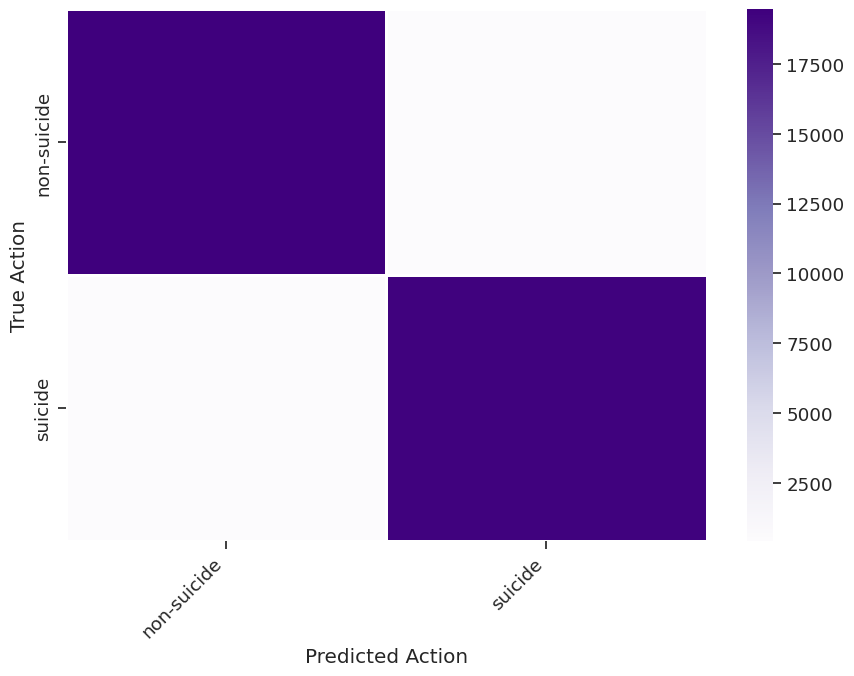

In [60]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')    
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [61]:
action_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, predicted_labels):
  if _true_label != _predicted_label: # Remove the diagonal to highlight misclassifications
    action_classifications_dict[(_true_label, _predicted_label)] += 1
  
dicts_to_plot = []
for (_true_action, _predicted_action), _count in action_classifications_dict.items():
  dicts_to_plot.append({'True Action': _true_action,
                        'Predicted Action': _predicted_action,
                        'Number of Classifications': _count})
  
df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Action', 
                                 columns='Predicted Action', 
                                 values='Number of Classifications')

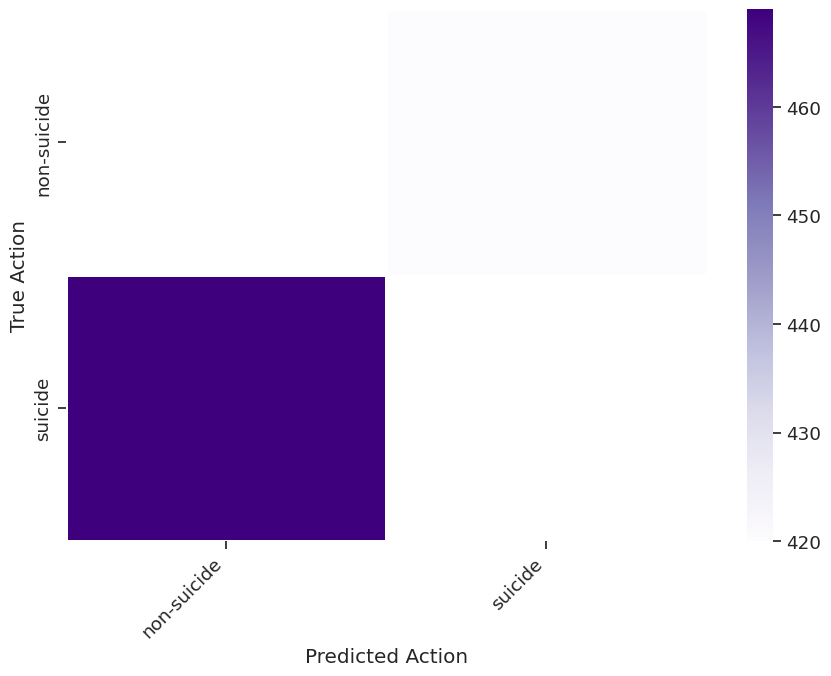

In [62]:
plt.figure(figsize=(9,7))
sns.set(style='ticks', font_scale=1.2)
sns.heatmap(df_wide, linewidths=1, cmap='Purples')    
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# trainer = DistilBertForSequenceClassification.from_pretrained(cached_model_directory_name)